## Chapter 13 – Convolutional Neural Networks - 卷积神经网络

虽然IBM的深蓝超级计算机在1996年击败了国际象棋世界冠军加里卡斯帕罗夫，直到最近，计算机无法可靠地执行看似琐碎的任务，例如在图片中检测小狗或识别口语。为什么这些任务对我们人类来说如此轻松？

答案在于，感知主要发生在我们意识领域之外，在我们大脑中的专业视觉，听觉和其他感官模块中。当感官信息达到我们的意识时，它已经被装饰了高级特征;

例如，当你看一只可爱的小狗的照片时，你不能选择不看小狗，或者不注意它的可爱。你也不能解释你如何识别一只可爱的小狗;这对你来说很明显。因此，我们不能相信我们的主观经验：感知根本不是微不足道的，要理解它，我们必须看看感官模块是如何工作的。卷积神经网络（CNNs）来自对大脑视觉皮层的研究，，自20世纪80年代以来，它们已被用于图像识别。

* 在过去几年中，由于计算能力的提高，可用训练数据的数量以及第11章中用于训练深网的技巧，CNN已经成功地在一些复杂的视觉任务上实现了超人的表现。它们为图像搜索服务，自动驾驶汽车，自动视频分类系统等提供动力。

* 此外，CNN不仅限于视觉感知：他们也在其他任务中取得成功，例如语音识别或自然语言处理（NLP）;但是，我们现在将专注于视觉应用。

在这一章当中我们将
* 介绍CNN来自哪里，
* 它们的构建块是什么样的，
* 以及如何使用TensorFlow实现它们。
* 然后我们将介绍一些最好的CNN架构。

**关于本文术语使用的一点说明**：

**feature maps**,既可以译作特征图，也可以译作特征映射，本文不做区分，其原意都是**feature maps**

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
# 更改为每行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "F:\ML\Machine learning\Hands-on machine learning with scikit-learn and tensorflow"
import os
PROJECT_ROOT_DIR = os.getcwd()
CHAPTER_ID = "13_CNN"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# 1. The Architecture of the Visual Cortex - 视觉皮层的结构

David H.Hubel 和 Torsten Wiesel 在 1958 年和 1959 年对猫进行了一系列实验（以及几年后在猴子上的实验），对视觉皮层的结构提供了重要的见解（1981 年作者因此获得了诺贝尔生理和医学奖）。具体来说，

* 他们发现视皮层中的许多神经元有一个小的局部感受野，这意味着它们只对位于视野中有限的一部分区域的视觉刺激起作用（见图 13-1，五个神经元的局部感受野由虚线圆圈表示）。

* 不同神经元的感受野可能重叠，并且它们一起平铺了整个视野。

* 此外，作者表明，一些神经元只对水平线方向的图像作出反应，而另一些神经元只对不同方向的线作出反应（两个神经元可能具有相同的感受野，但对不同方向的线作出反应）。

* 他们还注意到一些神经元具有较大的感受野，并且它们对较复杂的模式作出反应，这些模式是较低层模式的组合。

这些观察结果让我们想到：更高级别的神经元是基于相邻低级神经元的输出（在图 13-1 中，请注意，每个神经元只与来自前一层的少数神经元相连）。这个强大的结构能够检测视野中任何区域的各种复杂图案。



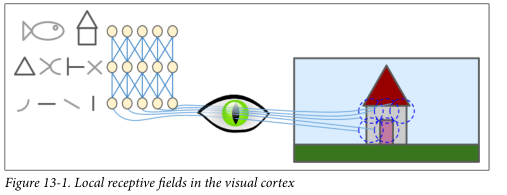

这些对视觉皮层的研究启发了 1980 年推出的新认知机（neocognitron），后者逐渐演变为我们现在称之为**卷积神经网络**。一个重要的里程碑是 Yann LeCun，LéonBottou，Yoshua Bengio 和 Patrick Haffner 于 1998 年发表的一篇论文，该论文引入了着名的 LeNet-5 架构，广泛用于识别手写支票号码。这个架构有一些你已经知道的构建块，比如**全连接层**和 **Sigmoid 激活函数**，但是它还引入了两个新的构建块：**卷积层和池化层**。现在我们来看看他们。

为什么不简单地使用具有完全连接层的常规深度神经网络来进行图像识别任务？不幸的是，虽然这适用于小图像（例如，MNIST），但由于需要大量参数，它会因较大的图像而崩溃。例如，100×100图像有10,000像素，如果第一层只有1000个神经元（这已经严重限制了传输到下一层的信息量），这意味着总共有1000万个连接。 这只是第一层。 CNN使用**部分连接的层**解决了这个问题。

一对实用程序用于绘制灰度和RGB图像：

In [3]:
import tensorflow as tf
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

# 2. Convolutional layer - 卷积层

**CNN 最重要的组成部分是卷积层**：

* 第一卷积层中的神经元没有连接到输入图像中的每个像素（就像前面章节中那样），而只是连接到它们感知区域中的像素（见图13-2）。

* 接着，第二卷积层中的每个神经元仅连接到位于第一层中的小矩形内的神经元。

这种架构允许网络专注于第一个隐藏层中的低级特征，然后将它们组装成下一个隐藏层中的更高级别特征，依此类推。这种分层结构在现实世界的图像中很常见，这也是CNN在图像识别方面表现良好的原因之一。

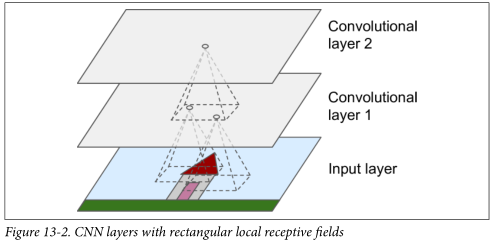

到目前为止，我们所看到的所有多层神经网络都有由一长串神经元组成的层，在输入到神经网络之前（**这里指末端输入到DNN之类**）我们必须将输入图像压缩成 1D。 现在，每个图层都以 2D 表示，这使得神经元与其相应的输入进行匹配变得更加容易。

位于给定层的第 $i$ 行，第 $j$ 列的神经元连接到该输出前一层位于行 $i$ 到 $i + f_h - 1$ ，列 $j$ 到 $j + f_w - 1$，中的神经元,其中 $f_h$ 和 $f_w$ 是感受野的高度和宽度（见图13-3）。

为了使图层具有与前一图层相同的高度和宽度，通常在输入周围添加零，如图所示。这称为**零填充**。

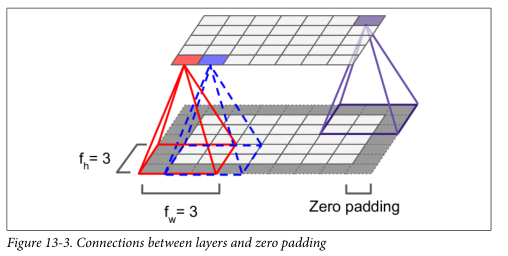

如图 13-4 所示，通过将局部感受野隔开，还可以将较大的输入层连接到更小的层。 两个连续的感受野之间的距离被称为**步幅**。 在图中，一个5×7的输入层（加零填充）连接到一个3×4层，使用3×3感受野和步幅2（在这个例子中，步幅在两个方向是相同的，但是它并不一定总是如此）。 位于上层第 $i$ 行第 $j$ 列的神经元与位于前一层中第 $i×s_h$ 至 $i × s_h + f_h – 1$ 行，第 j × s_w + f_w – 1 列 的神经元的输出连接， 其中 $S_h$ 和 $S_w$ 是垂直和水平的步幅。

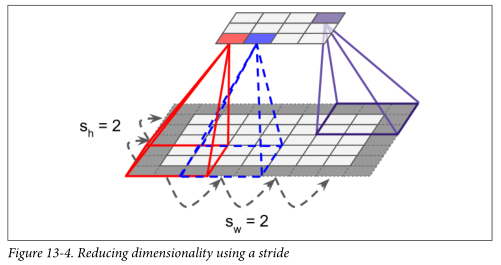

### 2.1 Filters - 卷积核/过滤器

神经元的权重可以表示为感受野大小的小图像。例如，图13-5显示了两组可能的权重，称为**过滤器（或卷积内核）**。

* 第一个表示为黑色正方形，中间有一条垂直的白线（除了中心列，它是一个7×7矩阵，全部为0，充满1s）;使用这些权重的神经元将忽略其感知域中的所有内容，除了中心垂直线（因为除了位于中心垂直线的输入之外，所有输入都将乘以0）。


* 第二个过滤器是一个黑色正方形，中间有一条水平白线。再一次，使用这些权重的神经元将忽略其感知域中的所有内容，除了中心水平线。



现在，
* 如果一个层中的所有神经元使用相同的**垂直线过滤器**（和相同的偏置项），然后向网络提供图13-5所示的输入图像（下图），图层将输出左上角的图像。请注意，垂直白线会增强，而其余部分会变得模糊。

* 同样，如果所有神经元都使用**水平线过滤器器**，右上角图像就是你得到的;注意到水平白线增强而其余部分模糊。

因此，使用相同过滤器的充满神经元的层给出了**特征图 -  feature map**，其突出显示图像中与过滤器最相似的区域。在训练期间，CNN为其任务找到最有用的过滤器，并且学会了将它们组合成更复杂的图案（例如，十字是图像中垂直滤波器和水平滤波器都是活动的区域）。

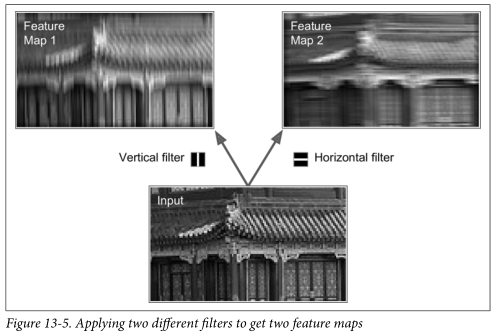

In [4]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
# image= china

height, width, channels = image.shape

image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)
images.shape

(1, 70, 120, 1)

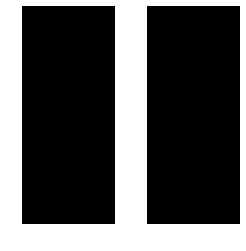

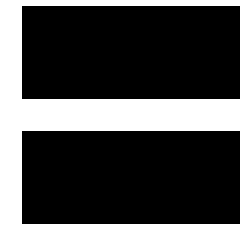

(7,)

(7, 7)

(7, 7, 1)

(7, 7, 1, 2)

(7, 2)

In [5]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()
fmap[:, 0, 0, 0].shape
fmap[:, :, 0, 0].shape
fmap[:, :, :, 0].shape
fmap[:, :, :, :].shape
fmap[:, 0, 0, :].shape
# def print_shape(row,col):
    

In [6]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

In [7]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})
output.shape

(1, 70, 120, 2)

Saving figure china_original


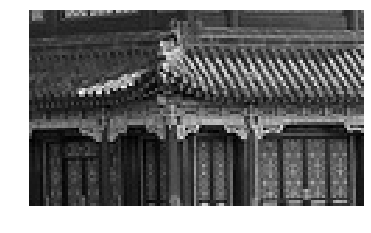

In [8]:
#images[batch,hight,weight,grayvalue]
# plot_image(images[0, :, :, 0])

plot_image(images[0,:,:,0])
# plot_color_image(image)
save_fig("china_original", tight_layout=False)
plt.show()

Saving figure china_vertical


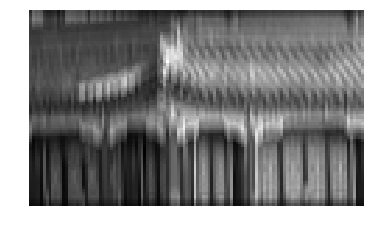

In [9]:
plot_image(output[0, :, :, 0])
save_fig("china_vertical", tight_layout=False)
plt.show()

Saving figure china_horizontal


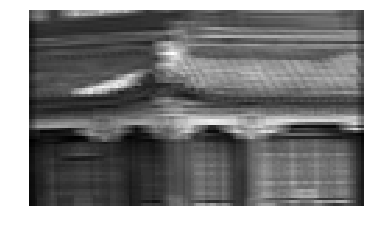

In [10]:
plot_image(output[0, :, :, 1])
save_fig("china_horizontal", tight_layout=False)
plt.show()

### 2.2 Stacking Multiple Feature Maps - 堆叠多个特征图

到目前为止，为简单起见，我们将每个卷积层表示为一个薄的2D层，但实际上它是由几个相同大小的特征图组成的，所以它更多
用3D精确表示（见图13-6）。

在一个特征图中，所有神经元共享相同的参数（权重和偏差项），但不同的特征图可能具有不同的参数。神经元的感受野与前面描述的相同，但它延伸到所有以前图层的特征图。简而言之，**卷积层同时将多个过滤器应用于其输入，使其能够在其输入中的任何位置检测多个特征**。


事实上，特征图中的所有神经元共享相同的参数，这大大减少了模型中的参数数量，但最重要的是，这意味着

* 一旦**CNN**学会识别一个位置的模式，它就可以在任何其他位置识别它。
* 相反，一旦**常规DNN**学会识别一个位置中的模式，它只可以在该特定位置识别它。

此外，输入图像也由多个子层组成：每个颜色通道一个。
* 通常有三种：红色，绿色和蓝色（RGB）。 
* 灰度图像只有一个通道，
* 但有些图像可能有更多——例如，捕获额外光频率的卫星图像（如红外线）。

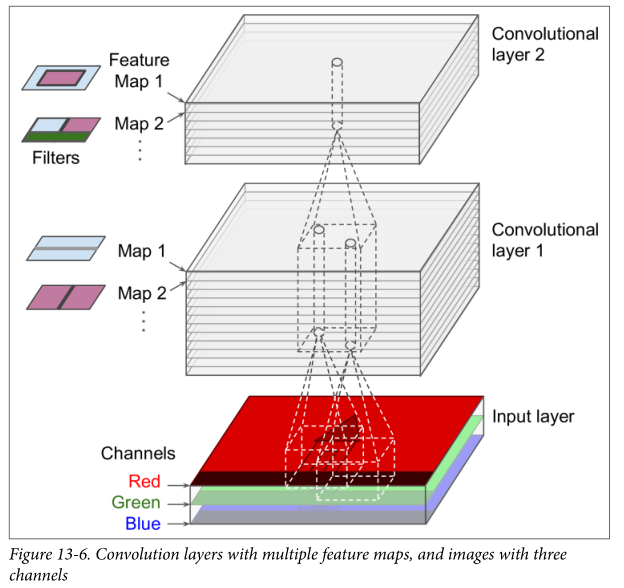

特别的，位于行 $i$ 中的神经元，给定卷积层 $l$ 中的特征映射 $k$ 的列 $j$ 连接到前一层 $l-1$中的神经元的输出，在所有特征图（在图层1-1中）中位于行 $i×s_w$ 到 $i×s_w + f_w-1$ ,列 $j×s_h$ 到 $j×s_h + f_h-1$。请注意，位于同一行 $i$ 和列 $j$ 但位于不同特征图中的所有神经元都连接到前一层中完全相同神经元的输出。


公式13-1在一个大数学方程式中总结了前面的解释：**它显示了如何计算卷积层中给定神经元的输出**。由于所有的指数不同，它有点难看，但它所做的只是计算所有输入的加权和加上偏差项。

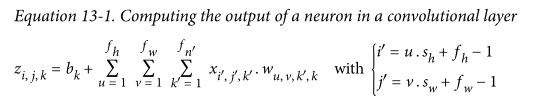

* $z_{i,j,k}$  是位于卷积层（层 $1$ ）的特征图 $k$ 中的行 $i$ ，列 $j$ 中的神经元的输出。

* 如前所述，$s h$ 和 $s w$ 是纵向和横向的步幅，

* $f h$ 和 $f w$ 是感受野的高度和宽度，$f n'$ 是前一层（层l-1）中的特征图的数量。

* $x_{i',j',k'}$  是位于层 $1-1$，行 $i'$，列 $j'$，特征图 $k'$（或如果前一层是输入层的通道 $k'$ ）中的神经元的输出。

* $b k$ 是特征图 $k$ 的偏差项（在层1中）。你可以将其视为调整特征图 $k$ 的整体亮度的旋钮。

* $w u, v, k′$  是层 $l$ 的特征图 $k$ 中的任何神经元与位于行 $u$，列 $v$（相对于神经元的感受野）的输入和特征图 $k'$之间的连接权重。

### 2.3 TensorFlow Implementation - TensorFlow实现

在TensorFlow中，

* 每个输入图像通常表示为[高度，宽度，通道]形状的3D张量。
* 小批量表示为[小批量，高度，宽度，通道]形状的4D张量。
* 卷积层的权重表示为[f h，f w，f n，f n']形状的4D张量。
* 卷积层的偏置项简单地表示为[f n]的形状1D张量。

让我们看一个简单的例子。下面的代码

* 使用Scikit-Learn的`load_sample_images（）`加载两个样本图像（加载两个彩色图像，一个是华人庙宇，另一个是花朵）。

* 然后它创建两个7×7过滤器（一个在中间有一条垂直的白线，另一个有一条水平的白线），

* 并使用TensorFlow的`conv2d（）`函数构建的卷积层将它们应用于两个图像（零填充和步长为2）。

* 最后，它绘制了一个结果特征图（类似于图13-5中的右上角图像）。

(427, 640, 3)

(3, 427, 640, 3)

(3, 214, 320, 2)

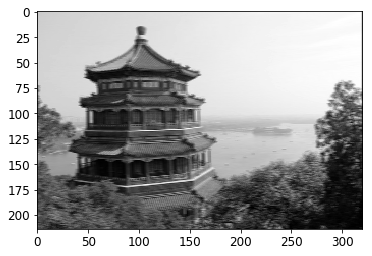

In [11]:
import numpy as np
from sklearn.datasets import load_sample_images

# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
china2 = load_sample_image("china.jpg")
china.shape
dataset = np.array([china, flower,china2], dtype=np.float32)
batch_size, height, width, channels = dataset.shape
dataset.shape
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# Create a graph with input X plus a convolutional layer applying the 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})
output.shape
plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

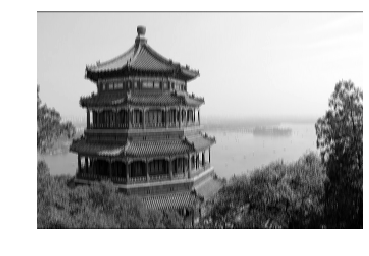

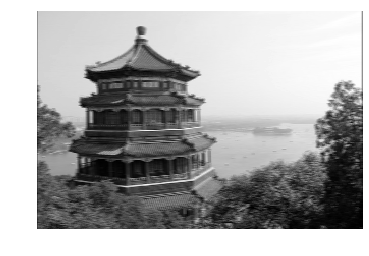

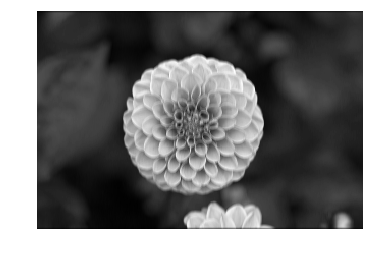

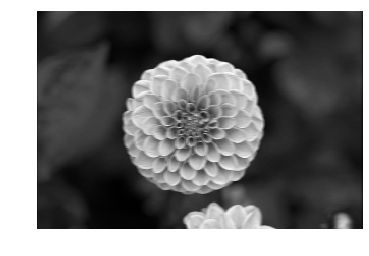

In [12]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

使用 `tf.layers.conv2d()`:

In [13]:
reset_graph()

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(
    X, 
    filters=2, 
    kernel_size=7, 
    strides=[2,2],
    padding="SAME"
)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.


大部分代码都是一目了然的，但是`conv2d（）`行应该得到一些解释：

* `X`是输入小批量（4D张量，如前所述）。


* `filters`是要应用的过滤器集（也是4D张量，如前所述）。


* `strides`是一个四元素1D数组，其中两个中心元素是垂直和水平步幅（$s_h$和$s_w$）。第一个和最后一个元素当前必须等于1。它们可能用于指定批量步幅（跳过某些实例）和通道步幅（跳过前一层的某些特征映射或通道）。


* `padding`必须是“VALID”或“SAME”：

  - 如果**设置为“VALID”，卷积层不使用零填充**，并且可能忽略输入图像底部和右侧的某些行和列，具体取决于步幅，如图13-7所示（为简单起见，仅此处显示水平尺寸，但当然相同的逻辑适用于垂直尺寸）。

  - 如果**设置为“SAME”，则卷积层在必要时使用零填充**。在这种情况下，输出神经元的数量等于输入神经元的数量除以步幅，向上舍入（在此示例中为ceil（13/5） ）= 3）。然后在输入周围尽可能均匀地添加零。

In [14]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})

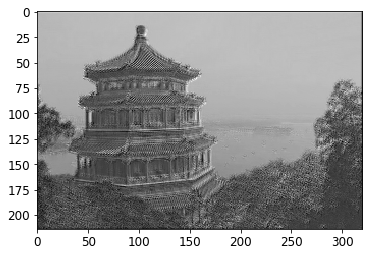

In [15]:
plt.imshow(output[0, :, :, 1], cmap="gray") # 绘制第一张图像的第二张特征图
plt.show()

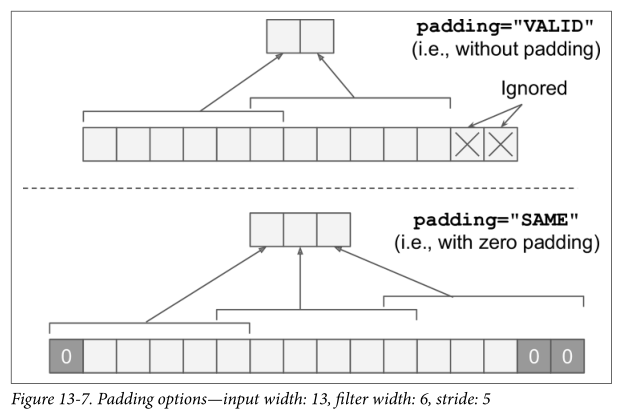

不幸的是，卷积层有很多超参数：**你必须选择过滤器的数量，高度和宽度，步幅和填充类型**。

和以前一样，你可以使用**交叉验证**来查找正确的超参数值，但这非常耗时。 我们稍后将讨论常见的CNN架构，以便让你了解在实践中最有效的超参数值。

## VALID vs SAME padding

In [16]:
reset_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

VALID:
 [[[[184.]
   [389.]]]]
SAME:
 [[[[143.]
   [348.]
   [204.]]]]


In [17]:
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))


VALID:
184.0
389.0
SAME:
143.0
348.0
204.0


### 2.4 Memory Requirements - 内存要求

CNN的另一个问题是卷积层需要大量的RAM，特别是在训练期间，因为反向传播的反向传递需要在前向传递期间计算的所有中间值。

例如，考虑具有$5×5$过滤器的卷积层，输出尺寸为150×100的200个特征图，带有步幅1和SAME填充。

* 如果输入是150×100 RGB图像（三个通道），那么参数的数量是$(5×5×3 + 1)×200 = 15,200$（$+1$对应于偏置项），这与完全连接的层相比相当小。 

* 然而，200个特征图中的每一个都包含$150×100$个神经元，并且这些神经元中的每一个都需要计算其$5×5×3 = 75$个输入的加权和：这总共有2.25亿次浮点乘法。没有完全连接的层那么糟糕，但仍然是计算密集型的。

* 此外，如果使用32位浮点数表示特征图，那么卷积层的输出将占用$200×150×100×32 = 96$百万位（约11.4 MB）的RAM。

这只是一个例子！如果训练批包含100个实例，则该层将占用超过1 GB的RAM！在推理期间（即，在对新实例进行预测时），一旦计算出下一层，就可以释放一层占用的RAM，因此你只需要两个连续层所需的RAM。



但是在训练期间，在正向传递期间计算的所有内容都需要保留用于反向传递，因此所需的RAM量（至少）是所有层所需的RAM总量。如果由于内存不足错误导致训练崩溃，

* 你可以尝试减少小批量。
* 或者，你可以尝试使用步幅减少维度，
* 或删除几层。
* 或者你可以尝试使用16位浮点数而不是32位浮点数。
* 或者你可以跨多个设备分配CNN。

现在让我们看看**CNN的第二个常见构建块：池化层**。

# 3. Pooling layer - 池化层

一旦了解了卷积层的工作原理，池化层就非常容易掌握了。他们的**目标是对输入图像进行二次采样（即缩小），以减少计算量，内存占用和参数数量（从而限制过拟合的风险）**。减小输入图像尺寸也使神经网络容忍一点点图像偏移（位置不变性）。

* 就像在卷积层中一样，池化层中的每个神经元都连接到前一层中有限数量神经元的输出，位于一个小的矩形感受野内。**你必须定义其大小，步幅和填充类型**，就像以前那样。

* 然而，池化神经元没有权重;它所做的就是使用聚合函数（如max或mean）聚合输入。

图13-8显示了最大池层，这是最常见的池层类型。在这个例子中，我们使用$2×2$池内核，步长为2，没有填充。请注意，只有每个内核中的最大输入值才能进入下一层。其他输入被删除。



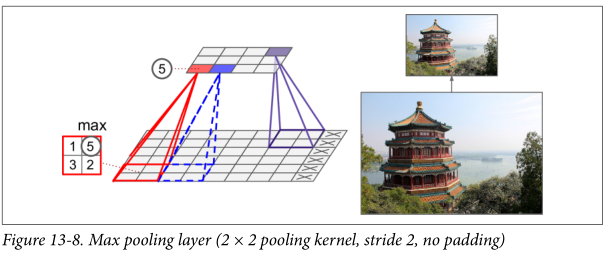

这显然是一种非常具有破坏性的层：即使使用$2×2$微小的内核和步幅 2 ，两个方向的输出也会小两倍（因此它的面积将减小四倍），只需输入75％的输入值。

池化层通常独立地在每个输入通道上工作，因此输出深度与输入深度相同。你也可以在深度维度上进行池化，如下所示，在这种情况下，图像的空间维度（高度和宽度）保持不变，但通道数量会减少。

在TensorFlow中实现最大池化层非常简单。以下代码
* 使用2×2内核，步幅2和无填充创建最大池化层，
* 然后将其应用于数据集中的所有图像：

In [18]:
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

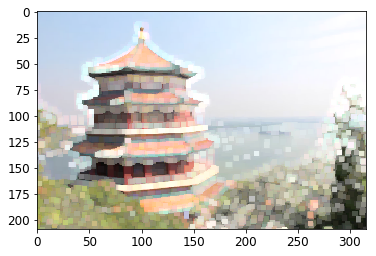

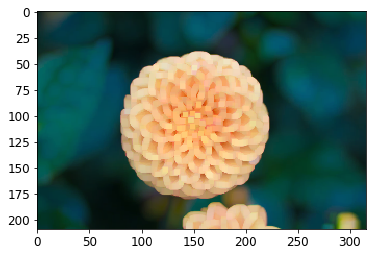

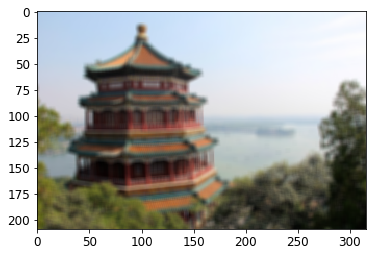

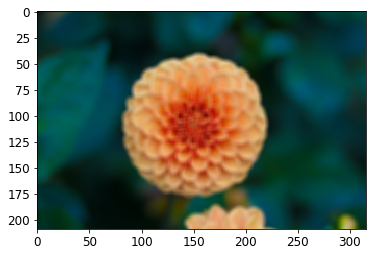

In [19]:
# Create a graph with input X plus a max pooling layer
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
# 最大池化
max_pool = tf.nn.max_pool(X, ksize=[1,10,10,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})
plt.imshow(output[0].astype(np.uint8))  # plot the output for the 1st image
plt.show()
plt.imshow(output[1].astype(np.uint8))  # plot the output for the 1st image
plt.show()
#平均池化
avg_pool = tf.nn.avg_pool(X, ksize=[1,10,10,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(avg_pool, feed_dict={X: dataset})
plt.imshow(output[0].astype(np.uint8))  # plot the output for the 1st image
plt.show()
plt.imshow(output[1].astype(np.uint8))  # plot the output for the 1st image
plt.show()

`ksize`参数包含输入张量的所有四个维度的内核形状：[批量大小，高度，宽度，通道]。

* TensorFlow目前不支持对多个实例进行池化，因此`ksize的第一个元素必须等于1`。

* 此外，它不支持在空间维度（高度和宽度）和深度维度上池化，因此`ksize [1]`和`ksize [2]`必须都等于1，或者`ksize [3]`必须等于1。

要创建**平均池化层**，只需使用`avg_pool（）`函数而不是`max_pool（）`

现在你知道所有创建卷积神经网络的构建块。 让我们看看如何组装它们。

Saving figure china_original


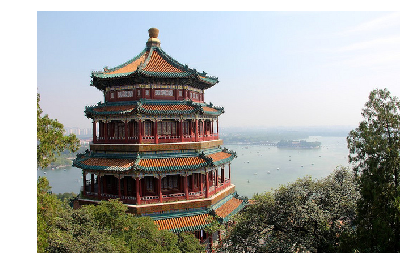

Saving figure china_max_pool


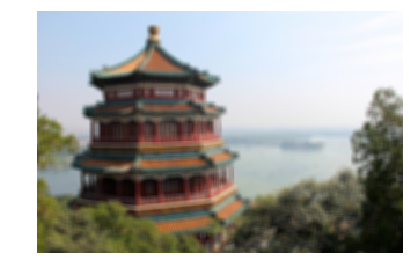

In [20]:
plot_color_image(dataset[0])
save_fig("china_original")
plt.show()
    
plot_color_image(output[0])
save_fig("china_max_pool")
plt.show()

# 4. CNN Architectures - CNN架构

**典型的CNN架构**堆叠了

* 一些卷积层（每个通常后跟一个ReLU层），
* 然后是一个池化层，
* 然后是另外几个卷积层（+ ReLU），
* 然后是另一个池层，

依此类推。

* 随着图像在网络中的进展，图像越来越小，但由于卷积层，它通常也会越来越深（即有更多的特征图）（见图13-9）。
* 在堆栈的顶部，添加了一个常规的前馈神经网络，由几个全连接的层（+ ReLU）组成，最后一层输出预测（例如，输出估计的类概率的softmax层）。

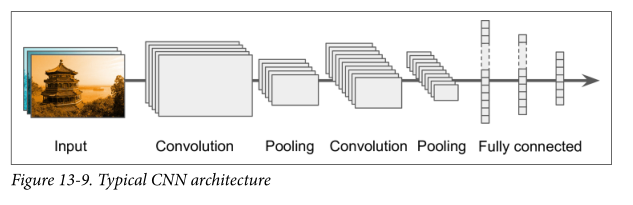

一个常见的错误是使用太大的卷积内核。通过将两个$3×3$内核堆叠在一起，你通常可以获得与$9×9$内核相同的效果，从而减少计算量。

这些年来，已经开发出这种基本架构的许多变体，导致该领域的惊人进步。衡量这一进展的一个很好的方法是竞赛中的错误率，例如**ILSVRC ImageNet**挑战赛。

在本次竞赛中，图像分类的前5个错误率在短短五年内从超过26％下降到仅略高于3％。前五个错误率是系统前5个预测未包含正确答案的测试图像数。图像很大（256像素高），有1000个类，其中一些非常微妙（尝试区分120种狗品种）。查看获奖作品的演变是了解CNN如何运作的好方法。

我们将
* 首先看一下经典的LeNet-5架构（1998），
* 然后是ILSVRC挑战的三个获胜者：AlexNet（2012），GoogLeNet（2014）和ResNet（2015）。

**其他视觉任务**

在其他视觉任务中也取得了令人瞩目的进展，例如**物体检测和定位**以及**图像分割**。

* 在物体检测和定位中，神经网络通常在图像中的各种对象周围输出一系列边界框。例如，请参阅Maxine Oquab等人的2015年论文，该论文为每个对象类输出热图，或者Russell Stewart等人的2015年论文，该论文使用CNN检测面部和复现神经网络的组合输出围绕它们的一系列边界框。


* 在图像分割中，网络输出图像（通常具有与输入相同的大小），其中每个像素指示相应输入像素所属的对象的类别。例如，查看Evan Shelhamer等人的2016年论文。

### 4.1 LeNet-5

LeNet-5 架构也许是最广为人知的 CNN 架构。 如前所述，它是由 Yann LeCun 于 1998 年创建的，广泛用于手写数字识别（MNIST）。 它由表 13-1 所示的层组成。

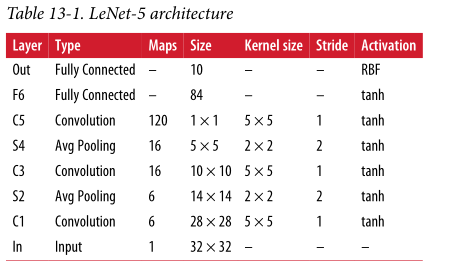

有一些额外的细节需要注意：

* MNIST图像是28×28像素，但是它们被零填充到32×32像素，在送入网络之前进行标准化。**网络的其余部分不使用任何填充**，这就是随着图像通过网络进展而尺寸不断缩小的原因。

* 平均池化层比平常更复杂：每个神经元计算其输入的平均值，然后将结果乘以可学习的系数（每个地图一个）并添加可学习的偏差项（再次，每个地图一个），然后最终应用激活函数。

* C3图中的大多数神经元仅与三个或四个S2图（而不是所有六个S2图）中的神经元相连。有关详细信息，请参阅原始文件中的表1。

* 输出层有点特殊：不是计算输入和加权矢量的点积，而是每个神经元输出其输入矢量与其权重矢量之间的欧几里德距离的平方。每个输出测量图像属于特定数字类的程度。交叉熵成本函数现在是首选，因为它可以更好地处理不良预测，产生更大的梯度，从而更快地收敛。

Yann LeCun的网站（“LENET”部分）展示了LeNet-5分类数字的精彩演示。

### 4.2 AlexNet

AlexNet CNN架构以绝对优势赢得了2012年ImageNet ILSVRC挑战赛：它实现了17％的前5个错误率，而第二个最好的只达到26％！
它由Alex Krizhevsky（因此得名），Ilya Sutskever和Geoffrey Hinton共同开发。它与LeNet-5非常相似，只是更大更深，它是第一个**将卷积层直接堆叠在彼此之上，而不是在每个卷积层顶部堆叠池化层**。 表13-2显示了此体系结构。

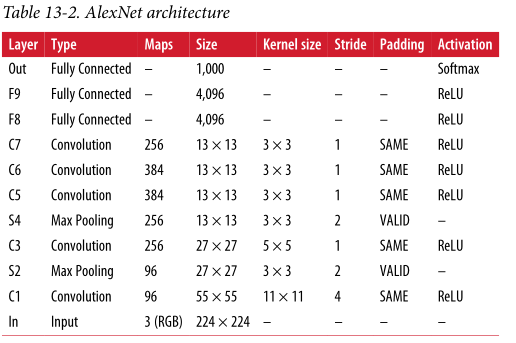

**为了减少过拟合**，作者使用了我们在前几章中讨论过的**两种正则化技术**：

* 首先，他们在训练期间将丢失（具有50％的丢失率）应用于层F8和F9的输出。 
* 其次，他们通过各种偏移**随机移动训练图像**，**水平翻转**它们，以及**改变照明条件来进行数据增强**。

AlexNet在层C1和C3的ReLU步骤之后也立即使用有竞争力的标准化步骤，称为**局部响应标准化**。这种标准化形式使得最强烈激活的神经元在相同位置但在相邻特征图中抑制神经元（在生物神经元中已经观察到这种竞争激活）。这鼓励不同的特征图专门化，将它们分开并迫使它们探索更广泛的特征，最终改进泛化。 公式13-2显示了如何应用LRN。
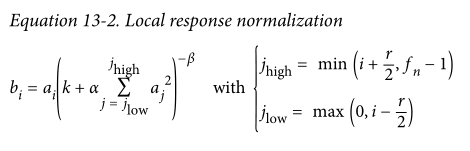

* $b_i$是位于特征图 $i$ 中，某行 $u$ 和列 $v$的神经元的归一化输出（注意，在这个等式中我们只考虑位于此行和列的神经元，因此未显示 $u$ 和$v$）。

* $a i$是在ReLU步骤之后但在归一化之前激活该神经元。

* $k,α,β和 r$ 是超参数.$k$ 称为偏差，$r$ 称为深度半径。

* $f n$ 是特征图的数量。

例如，如果$r = 2$ 并且神经元具有强激活，它会抑制位于其自身上下的特征图中的神经元的激活。在AlexNet中，超参数设置如下：$r = 2，α= 0.00002，β= 0.75，并且k = 1$。可以使用TensorFlow的`local_response_normalization（）`操作实现此步骤


AlexNet的一个名为ZF Net的变种是由Matthew Zeiler和Rob Fergus开发的并赢得了2013年ILSVRC的挑战。它本质上是AlexNet，有一些超参数的调整（特征映射的数量，内核大小，步幅等）。

### 4.3 GoogLeNet

GoogLeNet架构由来自谷歌研究的Christian Szegedy等人开发。它将前5个错误率推至7％以下，从而赢得了ILSVRC 2014年的挑战赛。这种出色的表现在很大程度上源于网络比以前的CNN更深的事实（见图13-11）。这是通过称为**初始模块**的子网络实现的，**允许GoogLeNet比以前的架构更有效地使用参数**：GoogLeNet实际上的参数比AlexNet少10倍（大约600万而不是6000万）。


图13-10显示了初始模块的体系结构。符号“$3×3 + 2（S）$”表示该层使用$3×3$内核，步幅2和SAME填充。

* 首先复制输入信号并将其馈送到四个不同的层。
* 所有卷积层都使用ReLU激活功能。请注意，第二组卷积层使用不同的内核大小（1×1,3×3和5×5），允许它们捕获不同比例的模式。

* 另请注意，每个单独层使用步幅 1 和SAME填充（即使是最大池化层），因此它们的输出都具有与其输入相同的高度和宽度。

这使得可以在最终深度连续层中连接沿深度维度的所有输出（即，堆叠来自所有四个顶部卷积层的特征图）。可以使用`concat（）`操作在TensorFlow中实现此连接层，其中`axis = 3`（轴3是深度）。

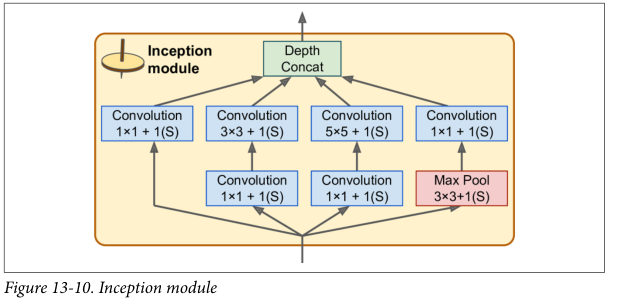

你可能想知道为什么初始模块具有$1×1$内核的卷积层。确定这些层无法捕获任何特征，因为它们一次只能看到一个像素？实际上，这些层有两个目的：

* 首先，它们被配置为输出比输入更少的特征映射，所以它们作为瓶颈层，意味着它们降低了维度。这在$3×3$和$5×5$卷积之前特别有用，因为这些是计算上非常昂贵的层。

* 第二，每对卷积层（[1×1，3×3]和[1×1，5×5]）的作用就像一个单一的，强大的卷积层，能够捕获更多复杂的图案。实际上，不是在图像上扫描简单的线性分类器（作为单个卷积层），这对卷积层扫过图像上的双层神经网络。

简而言之，你可以将整个初始模块视为类固醇上的卷积层，能够输出捕获各种尺度复杂模式的特征图。

每个卷积层的卷积核的数量是超参数。不幸的是，这意味着**你需要为你添加的每个初始层调整六个超参数**。

现在让我们来看看GoogLeNet CNN的架构（参见图13-11）。它非常深，以至于我们必须在三列中表示它，但GoogLeNet实际上是一个高堆栈，包括九个初始模块（带有旋转顶部的盒子），每个模块实际上包含三个层。每个卷积层和每个池化层输出的特征图的数量显示在内核大小之前。

初始模块中的六个数字表示模块中每个卷积层输出的特征图的数量（与图13-10中的顺序相同）。请注意，所有卷积层都使用ReLU激活函数。

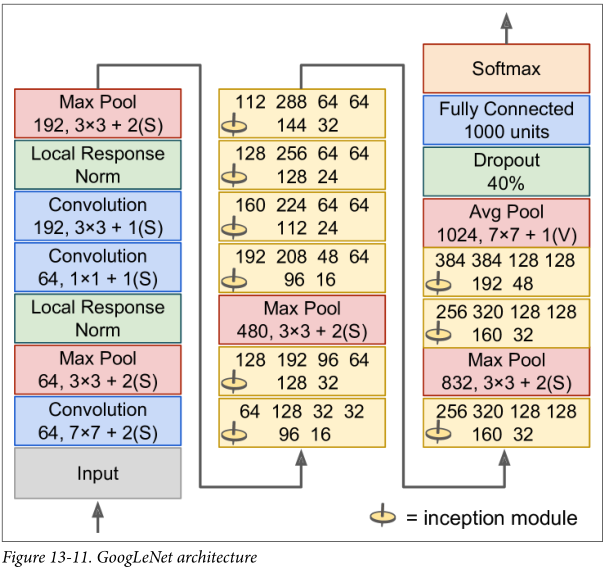

我们来看看这个网络：

* 前两层将图像的**高度和宽度除以4**（因此其面积除以16），以减少计算负荷。

* 然后，**本地响应规范化层**确保先前的层学习各种各样的特征（如前所述）。

* 接下来是**两个卷积层**，其中第一个层就像一个瓶颈层。如前面已经解释过，你可以把这对看作是一个更智能的卷积层。

* 再一次，本地响应规范化层确保先前的层捕获各种模式。

* 接下来，**最大池化层**将图像高度和宽度减小2，再次加快计算速度。

* 然后是**九个初始模块的高堆栈**，与几个最大池池交错，以减少维数并加速网络。

* 接下来，**平均池化层**使用具有**VALID填充**的特征图大小的内核，输出1×1特征图：这种令人惊讶的策略被称为全局平均池化。它有效地强制前面的层生成特征图，这些特征图实际上是每个目标类的置信映射（因为其他类型的特征将被平均步骤破坏）。这使得不必在CNN顶部有几个完全连接的层（如AlexNet），大大减少了网络中的参数数量并限制了过度拟合的风险。

* 最后一层是一目了然的：用于正则化的丢失，然后是具有softmax激活函数的完全连接的层，以输出估计的类概率。


该图略有简化：

* 最初的GoogLeNet架构还包括两个辅助分类器，它们插在第三和第六个初始模块之上。它们都是由一个平均池化层，一个卷积层，两个完全连接的层和一个softmax激活层组成。

* 在训练期间，他们的损失（按比例缩小70％）增加了整体损失。目标是消除梯度消失的问题并使网络正规化。 但是，它表明它们的影响相对较小。

### 4.4 ResNet

最后一个，2015年ILSVRC挑战赛的获胜者是由Kaiming He等人开发的**残差网络（或ResNet）**，它使用由152层组成的极深CNN，使得前5个错误率低于3.6％。

能够训练这种深度网络的关键是使用**跳跃连接**（也称为快捷连接）：进入每一层的信号也被添加到位于堆栈上方稍高的层的输出。让我们看看为什么这很有用。

在训练神经网络时，目标是使其建模一个目标函数h（x）。如果将输入 `x` 添加到网络的输出（即，添加跳跃连接），然后网络将被强制建模 $f(x)= h(x) - x$ 而不是 $h(x)$。这称为**残差学习**（见图13-12）。

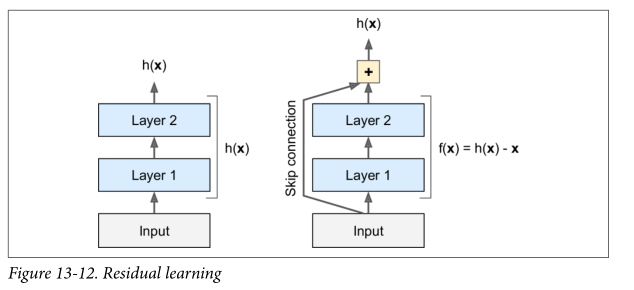

初始化常规神经网络时，其权重接近于零，所以网络只输出接近零的值。 如果添加跳跃连接，则生成的网络只输出其输入的副本; 换句话说，它最初建模身份函数（it initially models the identity function）（这个翻译的不准确，后面了解更多以后再改）。

* 如果目标函数非常接近身份函数（通常是这种情况），这将大大加快训练速度。
* 此外，如果添加许多跳跃连接，即使多个层尚未开始学习，网络也可以开始进行（参见图13-13）。

由于跳跃连接，信号可以轻松地穿过整个网络。 深度残差网络可被视为一堆残差单元，其中每个残差单元是具有跳跃连接的小型神经网络。

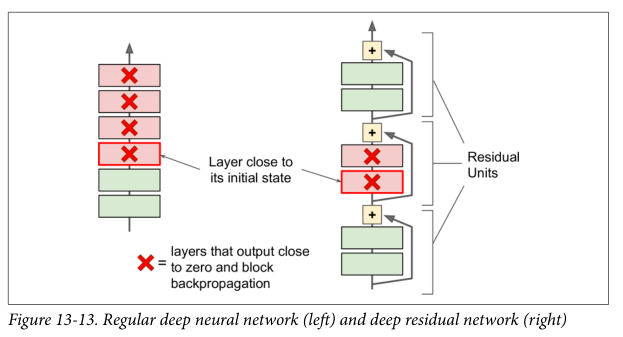

现在让我们看看ResNet的架构（参见图13-14）。它实际上非常简单。

* 它的开始和结束与GoogLeNet完全相同（除了没有丢失层），其间只是一个非常深的简单残差单元堆栈。

* 每个残差单元由两个卷积层组成，具有批量归一化（BN）和ReLU激活，使用$3×3$ 内核并保留空间维度（步幅1，SAME填充）。

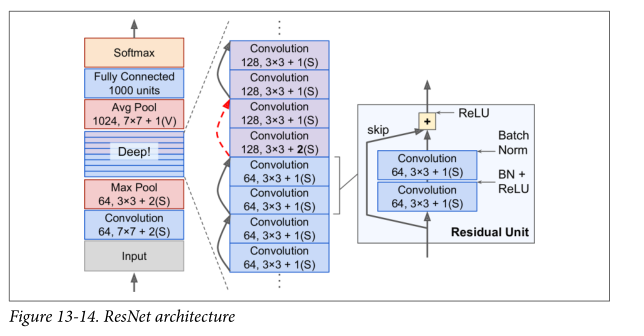

**请注意，每几个残差单元的特征图数量会加倍，同时它们的高度和宽度减半**（使用带有步幅2的卷积层）。发生这种情况时，不能直接添加到剩余单元的输出中，因为它们的形状不同（例如，此问题会影响图13-14中虚线箭头所示的跳跃连接）。

为了解决这个问题，输入通过$1×1$卷积层，带有步幅2和正确数量的输出特征图（见图13-15）。

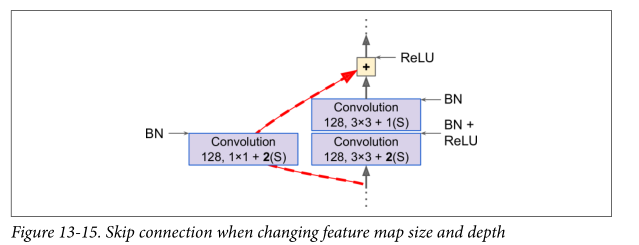

* ResNet-34是34层的ResNet（仅对卷积层和完全连接层进行计数）包含三个输出64个特征映射的残差单元，4个具有128个映射的RU，6个具有256个映射的RU和3个具有512个映射的RU。

* 更深层次的ResNets，例如ResNet-152，使用稍微不同的残差单元。他们使用三个卷积层而不是带有256个特征映射的两个$3×3$卷积层（例如）：

   * 首先是一个1×1的卷积层，只有64个特征图（少4倍），它作为一个瓶颈层（如前所述），然后是一个带有64个特征图的3×3层，
   * 最后是另一个1×1卷积层，具有256个特征图（4倍64），可恢复原始深度。

ResNet-152包含三个这样的RU，它们输出256个映射，然后是8个具有512个映射的RU，一个高达36个RU和1,024个映射，最后是3个具有2,048个映射的RU。

正如你所看到的，该领域正在迅速发展，各种各样的架构每年都在涌现。一个明显的趋势是CNN越来越深入。 它们也越来越轻，需要的参数越来越少。**目前，ResNet架构既是最强大的，也可能是最简单的架构，所以它实际上是你现在应该使用的架构，但每年都要关注ILSVRC的挑战**。

2016年的获奖者是来自中国的Trimps-Soushen团队，错误率高达2.99％。为了实现这一目标，他们训练了之前模型的组合并将它们组合成一个整体。根据任务的不同，降低的错误率可能或可能不值得额外的复杂性。

你可能还想看一些其他架构，特别是VGGNet 13（ILSVRC 2014挑战的亚军）和Inception-v4 14（它融合了GoogLeNet和ResNet的思想，在ImageNet分类上实现了接近3％的前5个错误率）。

实现我们刚刚讨论的各种CNN架构并没有什么特别之处。 我们之前看到了如何构建所有单独的构建块，因此现在**你只需要组装它们以创建所需的体系结构**。 我们将在即将到来的练习中**构建ResNet-34**，我们会在下面给出完整的工作代码。

**TensorFlow Convolution Operations**

TensorFlow还提供了一些其他类型的卷积层：

* `conv1d（）`为1D输入创建卷积层。例如，这在自然语言处理中是有用的，其中句子可以表示为单词的一维数组，并且接收字段覆盖几个相邻的单词。


* `conv3d（）`为3D输入创建卷积层，例如3D PET扫描。

* `atrous_conv2d（）`创建了一个令人生畏的卷积层（“àtrous”是法语“with holes”）。这相当于使用规则的卷积层，其中过滤器通过插入行和列（即，孔）而扩展。例如，等于[[1,2,3]]的$1×3$过滤器可以以4的膨胀率扩张，导致扩张过滤器[[1,0,0,0,2,0,0]， 0,3]]。这允许卷积层在没有计算代价的情况下具有更大的感受野并且不使用额外的参数。


* `conv2d_transpose（）`创建一个**转置卷积层**，有时称为**反卷积层**，它对图像进行上采样。它通过在输入之间插入零来实现，因此你可以将其视为使用分数步幅的常规卷积层。**上采样 - Upsampling**很有用，例如，在图像分割中：在典型的CNN中，当你在网络中前进时，要素图会变得越来越小，因此如果要输出与输入大小相同的图像，则需要上采样图层。

* `depthwise_conv2d（）`创建深度卷积层，将每个过滤器独立应用于每个输入通道。因此，如果存在 $f_n$个过滤器和 $f _n'$个输入通道，则这将输出$f_n×f_n'$个特征映射。

* `separable_conv2d（）`创建一个可分离的卷积层， 首先像深度卷积层一样，然后将 $1×1$ 卷积层应用于得到的特征映射。这使得可以将过滤器应用于任意输入通道组。

# MNIST

注意：我们现在使用`dense（），conv2d（）和dropout（）函数`，而不是使用`tensorflow.contrib.layers`模块中的`fully_connected（），conv2d（）和dropout（）函数`（如书中所示）。分别来自`tf.layers`模块，在编写本章时不存在。
这是首选，因为`contrib`中的任何内容都可能更改或删除，恕不另行通知，而`tf.layers` 是官方API的一部分。正如你将看到的，代码大致相同。

对于所有这些函数：

*  `scope` 参数已重命名为 `name`, 并且在具有该参数的所有参数中删除了`_fn`后缀（例如，activation_fn参数已重命名为 `activation`).

`tf.layers.dense()` 的其他主要区别是:
*  `weights` 参数重命名为 `kernel` (权重变量现在命名为 `"kernel"` 而不是 `"weights"`),
* 默认激活为 `None` 而不是 `tf.nn.relu`

`tf.layers.conv2d()` 的其他主要区别是:
*  `num_outputs` 参数已重命名为 `filters`,
*  `stride` 参数重命名为 `strides`,
*  默认 `activation` 现在是 `None` 而不是 `tf.nn.relu`.

`tf.layers.dropout()` 的其他主要区别是:
* 它需要 the dropout rate (`rate`) 而不是保持概率 -  keep probability (`keep_prob`).  当然， `rate == 1 - keep_prob`,
* `is_training` 参数已重命名为 `training`.

In [21]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
#卷积2连接卷积1
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dense instead.


In [22]:
X_reshaped.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

注意：如果你在OSX上使用Python 3.6，则需要在终端上运行以下命令来安装certifi证书包，因为OSX上的Python 3.6没有验证SSL连接的证书 。请参阅此StackOverflow问题[StackOverflow question](https://stackoverflow.com/questions/27835619/urllib-and-ssl-certificate-verify-failed-error)):

    $ /Applications/Python\ 3.6/Install\ Certificates.command

In [23]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [24]:
# n_epochs = 10
# batch_size = 100

# with tf.Session() as sess:
#     init.run()
#     for epoch in range(n_epochs):
#         for iteration in range(mnist.train.num_examples // batch_size):
#             X_batch, y_batch = mnist.train.next_batch(batch_size)
#             sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
#         acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
#         acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
#         print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

#         save_path = saver.save(sess, "./my_mnist_model")

# Exercise solutions

## 1. to 6.

请移步我的简书[Chapter - 13 Exercise(1-6)](https://www.jianshu.com/p/d3b1f4317e58)

## 7. High Accuracy CNN for MNIST

练习：建立自己的CNN并尝试在MNIST上实现尽可能高的准确性。

以下CNN类似于上面定义的CNN，除了使用步幅 1 用于第二卷积层（而不是2），在第二卷积层之后有25％的丢失，在完全连接的层之后有50％的丢失，并且使用提前停止训练。

它在MNIST上实现了大约99.2％的准确率。 这不是最先进的，但也不错。 你能做得更好吗？

In [25]:
import tensorflow as tf

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')
X_reshaped.shape
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


下载数据:

In [26]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


* `get_model_params（）`函数获取模型的状态（即所有变量的值），
* `restore_model_params（）`恢复先前的状态。

这用于加速提前停止：我们只是将它保存到内存中，而不是将目前为止找到的最佳模型存储到磁盘中。 在训练结束时，我们回滚到最佳模型。

In [27]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

现在让我们训练模型吧！ 这种早期停止的实现方式如下：

* 每**100次训练迭代**，它会**在验证集上评估模型**，
* 如果模型的性能优于目前为止找到的最佳模型，那么它将模型保存到RAM中，
* 如果连续100次评估没有进展，那么训练就会中断，
* 训练后，**代码恢复找到的最佳模型**。

In [28]:
import datetime
(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

'2019-04-18 12:39:54'

In [29]:
# n_epochs = 1000
# batch_size = 500

# print ('迭代次数%s'%str((mnist.train.num_examples // batch_size)))
# best_loss_val = np.infty
# check_interval = 50
# checks_since_last_progress = 0
# max_checks_without_progress = 20
# best_model_params = None 
# import datetime

# with tf.Session() as sess:
#     init.run()
#     for epoch in range(n_epochs):
#         for iteration in range(mnist.train.num_examples // batch_size):
# #             if iteration % 100 ==0:
# #                 print("100 iterations timecount:"+(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
#             X_batch, y_batch = mnist.train.next_batch(batch_size)
#             sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
#             if iteration % check_interval == 0:
#                 loss_val = loss.eval(feed_dict={X: mnist.validation.images,
#                                                 y: mnist.validation.labels})
#                 if loss_val < best_loss_val:
#                     best_loss_val = loss_val
#                     checks_since_last_progress = 0
#                     best_model_params = get_model_params()
#                 else:
#                     checks_since_last_progress += 1
# #                     if checks_since_last_progress > max_checks_without_progress:
# #                         print("iteration Early stopping!")
# #                         break
                            
#         acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
#         acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
#                                            y: mnist.validation.labels})
#         print(("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f} time {:s}".format(
#                   epoch, acc_train * 100, acc_val * 100, best_loss_val,(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))))
#         if checks_since_last_progress > max_checks_without_progress:
#             print("epoch Early stopping!")
#             break

#     if best_model_params:
#         restore_model_params(best_model_params)
#     acc_test = accuracy.eval(feed_dict={X: mnist.test.images,
#                                         y: mnist.test.labels})
#     print(("Final accuracy on test set:", acc_test))
#     save_path = saver.save(sess, "./my_mnist_model")

在测试集上内存溢出了

## 8.  Classifying large images using Inception v3.- 使用Inception v3对大图像进行分类。

### 8.1.

下载各种动物的图像。 

* 在Python中加载它们，例如使用`matplotlib.image.mpimg.imread（）`函数或`scipy.misc.imread（）`函数。 
* 调整大小和/或将它们裁剪为299×299像素，并确保它们只有三个通道（RGB），没有透明通道。
* 对Inception模型进行过训练的图像进行了预处理，使其值在-1.0到1.0之间，因此您必须确保图像也是如此。

In [30]:
width = 299
height = 299
channels = 3

(-0.5, 298.5, 298.5, -0.5)

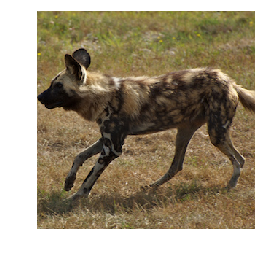

In [36]:
import matplotlib.image as mpimg

test_image = mpimg.imread(os.path.join(PROJECT_ROOT_DIR,"images","13_CNN","test_image.png"))[:, :, :channels]

plt.imshow(test_image)
plt.axis("off")
plt.show()

确保值在[-1,1]范围内（正如预先训练的Inception模型所预期的那样），而不是[0,1]：

In [37]:
test_image_bak = test_image
test_image = 2 * test_image - 1

## 8.2.

下载最新的预训练的Inception v3模型：检查点可在 https://github.com/tensorflow/models/tree/master/research/slim 上找到。 可以在 https://goo.gl/brXRtZ 上找到类名列表，但必须在开头插入 "background" 类。


In [38]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")

INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    print(tgz_path)
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)

    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)


In [39]:
fetch_pretrained_inception_v3()

In [40]:
url1 =  "https://github.com/tensorflow/models/blob/master/research/slim/slim_walkthrough.ipynb"
urllib.request.urlretrieve(url1, os.path.join("","slim_walkthrough.ipynb"), reporthook=download_progress)

Downloading: -6553600%

('slim_walkthrough.ipynb', <http.client.HTTPMessage at 0x14980375c50>)

In [41]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [42]:
class_names = ["background"] + load_class_names()

In [43]:
load_class_names()

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus',
 'brambling, Fringilla montifringilla',
 'goldfinch, Carduelis carduelis',
 'house finch, linnet, Carpodacus mexicanus',
 'junco, snowbird',
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'robin, American robin, Turdus migratorius',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel, dipper',
 'kite',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'vulture',
 'great grey owl, great gray owl, Strix nebulosa',
 'European fire salamander, Salamandra salamandra',
 'common newt, Triturus vulgaris',
 'eft',
 'spotted salamander, Ambystoma maculatum',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bullfrog, Rana catesbeiana',
 'tree frog, tree-f

## 8.3.

通过调用 `inception_v3()` 函数创建Inception v3模型，如下所示。 这必须在 `inception_v3_arg_scope()` 函数创建的参数范围内完成。 此外，你必须设置`is_training=False` and `num_classes=1001` [...]

In [44]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

### 8.4.

打开一个会话并使用“Saver”来恢复之前下载的预训练模型检查点。

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    # ...

### 8.5.

运行模型以对你准备的图像进行分类。 显示每个图像的前五个预测，以及估计的概率（类名列表可在https://goo.gl/brXRtZ获得）。 模型的准确度如何？

In [45]:
X_test = test_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt


In [46]:

most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

276

In [ ]:
class_names[most_likely_class_index]

In [47]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus: 93.13%
hyena, hyaena: 2.57%
European fire salamander, Salamandra salamandra: 0.06%
bearskin, busby, shako: 0.05%
swimming trunks, bathing trunks: 0.05%


该模型在这个特定图像上非常准确：如果能够高度自信地做出正确的预测。

## 9. Transfer learning for large image classification.- 用于大图像分类的迁移学习

### 9.1.
创建一个包含每个类至少100个图像的训练集。 例如，你可以根据位置（海滩，山峰，城市等）对自己的图片进行分类，或者你也可以使用现有的数据集，例如[flowers dataset](https://goo.gl/EgJVXZ) 或者 MIT's [places dataset](http://places.csail.mit.edu/)（需要注册，而且很大）.


让我们来处理鲜花数据集。 首先，我们需要下载它：

In [57]:
import sys
import tarfile
from six.moves import urllib

FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(FLOWERS_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "flower_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)

In [56]:
fetch_flowers()

Downloading: 100%

`flower_photos`目录的每个子目录都包含给定类的所有图片。 我们来看一下类别列表：

In [58]:
flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

['雏菊'，'蒲公英'，'玫瑰'，'向日葵'，'郁金香']

让我们得到每个类的**所有图像文件路径列表**：

In [59]:
from collections import defaultdict

image_paths = defaultdict(list)

for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[flower_class].append(os.path.join(image_dir, filepath))

让我们对图像路径进行排序，以使这个笔记本在多次运行中表现一致：

In [ ]:
for paths in image_paths.values():
    paths.sort()    

让我们来看看每个类的前几张图片：

In [ ]:
import matplotlib.image as mpimg

n_examples_per_class = 2

for flower_class in flower_classes:
    print("Class:", flower_class)
    plt.figure(figsize=(10,5))
    for index, example_image_path in enumerate(image_paths[flower_class][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:, :, :channels]
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

注意图像尺寸如何变化，以及在某些情况下（例如，第二郁金香图像）任务有多困难。

### 9.2.

编写预处理步骤：**调整大小并将图像裁剪为299×299，具有一些随机性的数据增强**。

首先，让我们使用NumPy和SciPy实现这个：

* 使用基本的NumPy切片进行图像裁剪，
* NumPy的 `fliplr()` 函数可以水平翻转图像（概率为50％），
* SciPy的 `imresize()` 函数用于缩放。
  * 请注意， `imresize()` 是基于Python图像库（PIL）。

有关更多图像处理功能（例如旋转），请查看[SciPy的文档](https://docs.scipy.org/doc/scipy-0.19.0/reference/ndimage.html) 或 [此页面](http://www.scipy-lectures.org/advanced/image_processing/).

In [ ]:
from scipy.misc import imresize

#from scipy.misc import skimage
#import skimage
#from skimage import transform

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # 首先，让我们找到最大的边界框，其中目标尺寸比率适合图像
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # 现在让我们用随机因子缩小这个边界框（将尺寸除以1.0到 1.0 +`max_zoom`之间的随机数。
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # 接下来，我们可以在图像上为此边界框选择一个随机位置。
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # 让我们使用我们构建的随机边界框裁剪图像。
    image = image[y0:y1, x0:x1]

    # 让我们也以50％的概率水平翻转图像：
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # 现在，让我们将图像调整为目标尺寸。
    image = imresize(image, (target_width, target_height))
    
    # 最后，让我们确保颜色表示为32位浮点数，范围从0.0到1.0（现在）：
    return image.astype(np.float32) / 255

注意：

* 在测试时，预处理步骤应该尽可能轻，只需要能够将图像投喂到神经网络所需的最小值。
* 你可能需要调整上述函数以添加`training`参数：如果为`False`，则应将预处理限制在最低限度（即，不翻转图像，只需要最小裁剪，保留图像的中心）。

我们来看看这张图片的结果：

In [ ]:
plt.figure(figsize=(6, 8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

There we go:

In [ ]:
prepared_image = prepare_image(example_image)

plt.figure(figsize=(8, 8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

现在让我们看一下从同一原始图像生成的一些其他随机图像：

In [ ]:
rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

看起来还可以

或者，也可以使用`tf.image`模块中的函数直接使用TensorFlow实现此图像预处理步骤（有关完整列表，请参阅[the API](https://www.tensorflow.org/api_docs/python/)）。正如你所看到的，此函数与上面的函数非常相似，除了它实际上不执行图像转换，而是创建一组TensorFlow操作，这些操作将在你运行图形时执行转换。

In [ ]:
def prepare_image_with_tensorflow(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""
    """随机缩放和裁剪图像以进行数据增强"""
    
    # 首先，让我们找到最大的边界框，其中目标尺寸比率适合图像
    image_shape = tf.cast(tf.shape(image), tf.float32)
    height = image_shape[0]
    width = image_shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = tf.cond(crop_vertically,
                         lambda: width,
                         lambda: height * target_image_ratio)
    crop_height = tf.cond(crop_vertically,
                          lambda: width / target_image_ratio,
                          lambda: height)

    # 现在让我们用随机因子缩小这个边界框（将尺寸除以1.0到 1.0 +`max_zoom`之间的随机数。
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = tf.random_uniform(shape=[], minval=1.0, maxval=1.0 + max_zoom)
    crop_width = tf.cast(crop_width / resize_factor, tf.int32)
    crop_height = tf.cast(crop_height / resize_factor, tf.int32)
    box_size = tf.stack([crop_height, crop_width, 3])   # 3 = number of channels

    # 让我们使用我们计算的大小的随机边界框裁剪图像
    image = tf.random_crop(image, box_size)

    # 让我们也以50％的概率水平翻转图像：
    image = tf.image.random_flip_left_right(image)

    # resize_bilinear函数需要4D张量（一批图像），因此我们需要首先扩展维数：
    image_batch = tf.expand_dims(image, 0)

    # 最后，让我们将图像的大小调整为目标尺寸。 请注意，此函数返回float32张量。
    # returns a float32 tensor.
    image_batch = tf.image.resize_bilinear(image_batch, [target_height, target_width])
    image = image_batch[0] / 255  # back to a single image, and scale the colors from 0.0 to 1.0
    return image

让我们测试一下这个函数

In [ ]:
reset_graph()

input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
prepared_image_op = prepare_image_with_tensorflow(input_image)

with tf.Session():
    prepared_image = prepared_image_op.eval(feed_dict={input_image: example_image})
    
plt.figure(figsize=(6, 6))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

Looks perfect!

### 9.3.

* 使用上一练习中预先训练的Inception v3模型，
* 将所有层冻结到瓶颈层（即输出层之前的最后一层），
* 并将输出层替换为新分类任务的适当数量的输出（例如， flowers数据集有五个互斥的类，因此输出层必须有五个神经元并使用softmax激活函数）。

让我们首先再次获取初始v3图。 这一次，让我们**使用一个训练占位符来告诉TensorFlow我们是否正在训练网络**（这是dropout和批量规范化等操作所需要的）。

In [ ]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

现在我们需要在图中**找到我们应该附加新输出层的点**。 它应该是当前输出层之前的层。 一种方法是探索输出层的输入：

In [ ]:
logits.op.inputs[0]

不，这是输出层的一部分（添加偏见）。 让我们继续在图表中向后走：

In [ ]:
logits.op.inputs[0].op.inputs[0]

这也是输出层的一部分，它是初始层中的最后一层（如果你不确定可以使用TensorBoard显示图形）。 再一次，让我们继续在图表中向后走：

In [ ]:
logits.op.inputs[0].op.inputs[0].op.inputs[0]

啊哈！ 我们在那里，这是丢失层的输出。 这是Inception v3网络中输出层之前的最后一层，因此这是我们需要构建的层。 请注意，实际上有一种更简单的方法可以找到这个层：`inception_v3（）`函数返回一个端点的dict：

In [ ]:
end_points

正如你所看到的，“PreLogits”终点正是我们所需要的：

In [ ]:
end_points["PreLogits"]

我们可以使用`tf.squeeze（）`函数删除第二维和第三维：

In [ ]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

然后我们可以在这个层的顶部添加最终完全连接的层：

In [ ]:
n_outputs = len(flower_classes)

with tf.name_scope("new_output_layer"):
    flower_logits = tf.layers.dense(prelogits, n_outputs, name="flower_logits")
    Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")

最后，我们需要添加通常的点点滴滴：

* 目标的占位符（y），
* 损失函数，即交叉熵，通常用于分类任务，
* 一个优化器，我们用它来创建一个最小化成本函数的训练操作，
* 一对操作来衡量模型的准确性，
* 最后是initializer 和 saver。

但是有一个重要的细节：因为我们只想训练输出层（所有其他层必须被冻结）， **我们必须传递变量列表来训练优化器的`minimize（）`方法**：

In [ ]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="flower_logits")
    training_op = optimizer.minimize(loss, var_list=flower_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 

In [ ]:
[v.name for v in flower_vars]

请注意，我们在添加新输出层之前创建了`inception_saver`：

* 我们将使用此保护程序来恢复预训练模型状态，因此我们不希望它尝试恢复新变量（它只会失败，说它不知道新变量）。 
* 第二个保护程序将用于保存最终的模型，包括预训练变量和新变量。

### 9.4.

将数据集拆分为训练集和测试集。 **在训练集上训练模型并在测试集上进行评估**。

首先，我们希望**将类表示为int而不是字符串**：

In [ ]:
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids

如果我们将数据集集表示为文件路径/类对列表，则更容易对数据集进行洗牌：

In [ ]:
flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    for path in paths:
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))

接下来，让我们对数据集进行洗牌并将其拆分为训练集和测试集：

In [ ]:
test_ratio = 0.2
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(flower_paths_and_classes)

flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]

让我们看一下训练集中的前3个实例：

In [ ]:
flower_paths_and_classes_train[:3]

接下来，我们还需要**一个预处理一组图像的函数**。 此函数对于预处理测试集以及在训练期间创建批次非常有用。 为简单起见，我们将使用NumPy / SciPy实现：

In [ ]:
from random import sample

def prepare_batch(flower_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 # 初始期望颜色范围从-1到1
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

In [ ]:
X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size=4)

In [ ]:
X_batch.shape

In [ ]:
X_batch.dtype

In [ ]:
y_batch.shape

In [ ]:
y_batch.dtype

看起来不错。 现在让我们使用这个函数来准备测试集：

In [ ]:
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=len(flower_paths_and_classes_test))

In [ ]:
X_test.shape

我们可以以相同的方式准备训练集，但它只会为每个图像生成一个变体。相反，最好在训练期间动态生成训练批次，这样我们才能真正受益于**数据增强**，每个图像都有许多变体。

现在，**我们已经准备好训练网络**（或者更确切地说，我们刚刚添加的输出层，因为所有其他层都被冻结）。 请注意，这可能需要（非常）很长时间。


我用的是自己的笔记本，所以下面两个cell 我没有运行，大家量力而为

In [ ]:
n_epochs = 10
batch_size = 40
n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Train accuracy:", acc_train)

        save_path = saver.save(sess, "./my_flowers_model")

In [ ]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, "./my_flowers_model")

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("Test accuracy:", acc_test)

好吧，70.58％的准确度不是很好（事实上，它确实很糟糕），但这只是在10个epochs 之后，并冻结了除输出层之外的所有层。

如果你有GPU，你可以再试一次，让训练运行更长时间（例如，使用提前停止来决定何时停止）。你还可以改进图像预处理功能，以对图像进行更多调整（例如，更改亮度和色调，稍微旋转图像）。你可以在此任务上达到95％以上的准确率。 如果你想深入挖掘，这篇精彩的[博文](https://kwotsin.github.io/tech/2017/02/11/transfer-learning.html)会详细介绍，准确度达到96％。

## 10.
浏览TensorFlow的[DeepDream tutorial](https://goo.gl/4b2s6g). 这是一种有趣的方式，让您熟悉可视化CNN学习模式的各种方法，并使用深度学习生成艺术。

只需下载笔记本并按照其说明操作即可。为了获得额外的乐趣，你可以通过反复放大和运行DeepDream算法来生成一系列图像：

使用[ffmpeg](https://ffmpeg.org/)等工具，您可以根据这些图像创建视频。
例如，这是我制作的[DeepDream video](https://www.youtube.com/watch?v=l6i_fDg30p0)视频......正如你将看到的，它很快变成了一场噩梦。;-)

你可以在网上找到数百个类似的视频（通常更具艺术性）。